In [18]:
from utils import *

data_path = "../data/XPSG - available resources/"
train_path = "../data/train/" # path of processed training data
valid_path = "../data/valid/" # path of processed validation data
processed_path = "../data/processed/"
model_path = '../models/'

train_dir = data_path+"French Ligue One 20162017 season - Match Day 1- 19/" # path of raw data
player_info = data_path+"Players and IDs - F40 - L1 20162017.xml"
test_before_change_eg = data_path+"Example test base before changes specified in the Rules -f24-24-2016-853139-eventdetails_test_hackathon_1.xml"
test_change_eg = data_path+"Example test base file - f24-24-2016-853285-eventdetails_test_hackathon_2.xml"

In [124]:
def construct_one_train(choice_xml, low, high):
    """
    Construct one training set.
    args:
        choice_xml: the xml of the chosen game whose type is lxml.etree._ElementTree.
        low: the start minute of the game.
        high: the end minute of the game.
    return:
        train_xml: the xml of one validation set whose type is lxml.etree._ElementTree.
        label_csv: the csv file of label results of this validation set.
        
    """
    suff_plyr_list = suff_plyr(choice_xml)
    if suff_plyr_list==[]:
        return [None, None]
    
    pick_plyr_id = suff_plyr_list[rnd.randint(0,len(suff_plyr_list)-1)] # randomly choose a sufficient player
    events = choice_xml.xpath('//Event')
    if low<45:
        half_type = 1
    else:
        half_type = 2
    half_events = [i for i in events if i.attrib['period_id']==str(half_type)]
    pick_events = [i for i in half_events if low<=(int(i.attrib['min'])+float(i.attrib['min'])/60)<=high]
    # check there are suff_plyrs in events
    if not suff_plyr_event(pick_events, suff_plyr_list):
        return [None, None]
    
    game = choice_xml.xpath('//Game')[0]
    home_id = game.attrib['home_team_id']
    away_id = game.attrib['away_team_id']
    
    
    game.attrib['timestamp'] = "" 
    for i in game.attrib.keys(): # substitute before info
        game.attrib[i] = ""
        
    for i in pick_events: # substitute team_id and other info
        # if 'player_id' in i.attrib:
        #    i.attrib['player_id'] = str(int(i.attrib['player_id']==pick_plyr_id))
        if 'team_id' in i.attrib:
            i.attrib['team_id'] = str(int(i.attrib['team_id']==home_id))
        if 'id' in i.attrib:
            i.attrib['id'] = ""
        if 'timestamp' in i.attrib:
            i.attrib['timestamp'] = ""
        if 'last_modified' in i.attrib:
            i.attrib['last_modified'] = ""
        if 'version' in i.attrib:
            i.attrib['version'] = ""
        
        for j in i.xpath('Q'):
            j.attrib['id'] = ""
            # When Type ID=140 and 141, qualifier_id=140/141 appears, replace the values by ""
            if ('qualifier_id' in j.attrib) and (j.attrib['qualifier_id'] == "140" or j.attrib['qualifier_id'] == "141"):
                j.attrib['qualifier_id'] = j.attrib['value'] = ""
        
    for i in pick_events[0:-10]: # substitute ball coor.
        i.attrib['x'] = i.attrib['y'] = "0.0"
    
    for i in pick_events[-10:]: # substitute the last 10 events
        i.attrib['outcome'] = ""
        for j in i.xpath('Q'):
            j.getparent().remove(j) # same as example
        #     j.attrib['qualifier_id'] = j.attrib['value'] = ""
    
    next_event_idx = choice_xml.xpath('//Event').index(pick_events[-1])+1 
    next_event = events[next_event_idx] # next event
    results = str(pick_plyr_id[1:]) + ',' + str(int(next_event.attrib['team_id']==home_id)) + ',' + \
                            str(next_event.attrib['x'])+ ',' + str(next_event.attrib['y']) # the label results
    label_csv = str(results)
    
    other_event = list(set(choice_xml.xpath('//Event')).difference(set(pick_events)))
    for j in other_event:
            j.getparent().remove(j)            
    tr_xml = choice_xml # Construct val_xml
    
    return [tr_xml, label_csv]

In [125]:
def construct_train_sets(save_path=train_path):
    """
    Construct numbers of validation set.
    args:
        save_path: the path of saving validation sets.
        val_num: the number of validation sets.
    return:
        a bool if the construction is success. 
    """
    files= os.listdir(train_dir)
    files = [i for i in files if i[0:3]=='f24']
    choice_min = [i*7.5 for i in range(11)]
    for choice_file_idx in tqdm(range(len(files))):
        for low in choice_min:
            # do while loop until returns are not None
            choice_xml = lxml.etree.parse(train_dir+files[choice_file_idx]) # randomly choose one game
            tr_xml, label_csv = construct_one_train(choice_xml, low, low+15)
            if not os.path.exists(save_path+str(choice_file_idx)):
                os.mkdir(save_path+str(choice_file_idx))
            if tr_xml==None:
                print(choice_file_idx, ' is none')
                continue
            try:
                tr_xml.write(save_path+str(choice_file_idx)+'/tr_' + str(low) + '.xml')
                with open(save_path+str(choice_file_idx)+'/label_' + str(low) + '.csv', 'w') as f:
                    f.write(label_csv)
            except IOError:
                print("Write error!")
                return False

In [126]:
def suff_plyr_event(pick_events, suff_plyr_list):
    """
    Justify if there are players in suff_plyr_list is in pick_events.
    args:
        pick_events: the picked events of the chosen game.
    return:
        Bool type.
        
    """
    for i in pick_events:
        if 'player_id' in i.attrib:
            player_id = 'p'+i.attrib['player_id']
            if player_id in suff_plyr_list:
                return True
    return False

In [127]:
construct_train_sets()









  0%|          | 0/190 [00:00<?, ?it/s]







  1%|          | 1/190 [00:01<05:13,  1.66s/it]







  1%|          | 2/190 [00:03<05:06,  1.63s/it]







  2%|▏         | 3/190 [00:05<05:13,  1.68s/it]







  2%|▏         | 4/190 [00:06<05:11,  1.67s/it]







  3%|▎         | 5/190 [00:08<05:08,  1.67s/it]







  3%|▎         | 6/190 [00:09<05:05,  1.66s/it]







  4%|▎         | 7/190 [00:11<05:01,  1.65s/it]







  4%|▍         | 8/190 [00:13<05:00,  1.65s/it]







  5%|▍         | 9/190 [00:14<04:53,  1.62s/it]







  5%|▌         | 10/190 [00:16<04:51,  1.62s/it]







  6%|▌         | 11/190 [00:18<04:48,  1.61s/it]







  6%|▋         | 12/190 [00:19<04:50,  1.63s/it]







  7%|▋         | 13/190 [00:21<04:45,  1.61s/it]







  7%|▋         | 14/190 [00:23<04:51,  1.66s/it]







  8%|▊         | 15/190 [00:24<04:54,  1.69s/it]







  8%|▊         | 16/190 [00:26<04:48,  1.66s/it]







  9%|▉         | 17/190 [00:27<04:42,  1.64s/it]







  

 54%|█████▎    | 102/190 [02:47<02:22,  1.62s/it]







 54%|█████▍    | 103/190 [02:49<02:22,  1.63s/it]







 55%|█████▍    | 104/190 [02:50<02:20,  1.64s/it]







 55%|█████▌    | 105/190 [02:52<02:19,  1.64s/it]







 56%|█████▌    | 106/190 [02:53<02:15,  1.61s/it]







 56%|█████▋    | 107/190 [02:55<02:12,  1.59s/it]







 57%|█████▋    | 108/190 [02:57<02:11,  1.61s/it]







 57%|█████▋    | 109/190 [02:58<02:11,  1.63s/it]







 58%|█████▊    | 110/190 [03:00<02:09,  1.62s/it]







 58%|█████▊    | 111/190 [03:02<02:16,  1.72s/it]







 59%|█████▉    | 112/190 [03:03<02:14,  1.72s/it]







 59%|█████▉    | 113/190 [03:05<02:13,  1.73s/it]







 60%|██████    | 114/190 [03:07<02:11,  1.72s/it]







 61%|██████    | 115/190 [03:09<02:11,  1.75s/it]







 61%|██████    | 116/190 [03:10<02:08,  1.73s/it]







 62%|██████▏   | 117/190 [03:12<02:05,  1.71s/it]







 62%|██████▏   | 118/190 [03:14<02:06,  1.76s/it]







 63%|██████▎   | 119/190 [03:16

In [ ]:
def trans_train_set_to_seq_data(path=train_path):
    """
    Transfer the training data which are in .xml and .csv into 3 sequence data (e.g. .csv).
    3 sequences are:
        - team event sequence (event sequences before the last 10)
        - event sequence (the last 10 events)
        - player sequence (all event sequence about some particular player)
    args:
        
    return:
        Bool type.
        
    """
    dirs = os.listdir(path)
    dirs = [i for i in dirs if '.' not in i]
    dirs = list(range(len(dirs)))
    for d in dirs:
        d = str(d)
        construct_team_seq(train_path+d+'/')
        construct_event_seq(train_path+d+'/')
        construct_player_seq(train_path+d+'/')

In [99]:
def construct_team_seq(path):
    train_df = pd.DataFrame({"min":[],
                             "sec":[],  
                             "type_id":[],
                             "keypass":[],
                             "assist":[],
                             "q_num":[]
                             })
    
    files = os.listdir(path)
    xml_files = [i for i in files if 'xml' in i]
    csv_files = [i for i in files if 'csv' in i]
    xml_files.sort()
    csv_files.sort()
    
    for file_idx in range(len(xml_files)):
        xfile = xml_files[file_idx]
        cfile = csv_files[file_idx]
        choice_xml = lxml.etree.parse(path+xfile)
        ground_truth = pd.read_csv(valid_dir+csv_files[i], header=None)
        events = choice_xml.xpath('//Event')
        team_0_events = [i for i in events if i.attrib['team_id']=='0']
        team_1_events = [i for i in events if i.attrib['team_id']=='0']
        
        for i in team_0_events:
            if (i.attrib['type_id']=='34') or (i.attrib['type_id']=='32'):
                continue
            mic = int(i.attrib['min'])
            sec = int(i.attrib['sec'])
            type_id = int(i.attrib['type_id'])
            keypass = int('keypass' in events[i].attrib)
            assist = int('assist' in events[i].attrib)
            
        for i in team_1_events:
            if (i.attrib['type_id']=='34') or (i.attrib['type_id']=='32'):
                continue
            mic = int(i.attrib['min'])
            sec = int(i.attrib['sec'])
            keypass = int('keypass' in events[i].attrib)
            assist = int('assist' in events[i].attrib)
        

In [ ]:
def construct_event_seq(path):
    

In [85]:
def construct_player_seq(path):
    

501

In [119]:
a = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0,
                16.0, 17.0, 18.0, 19.0, 20.0, 25.0, 27.0, 28.0, 30.0, 32.0, 40.0, 41.0, 42.0,
                43.0, 44.0, 45.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0,
                59.0, 60.0, 61.0, 65.0, 68.0, 70.0, 74.0]

In [122]:
xfile = xml_file[0]
choice_xml = lxml.etree.parse(path+xfile)
events = choice_xml.xpath('//Event')
team_0_events = [i for i in events if i.attrib['team_id']=='0']

OSError: Error reading file '../data/train/1/tr_1.xml': failed to load external entity "../data/train/1/tr_1.xml"

In [185]:
files = os.listdir(train_dir)
files = [i for i in files if i[0]!='.']
event_res = set()
for i in files:
    choice_xml = lxml.etree.parse(train_dir+i)
    event = choice_xml.xpath('//Event')
    for i in event:
        event_res.add(int(i.attrib['type_id']))   

In [138]:
files = os.listdir(train_dir)
files = [i for i in files if i[0]!='.']
q_res = set()
for i in files:
    choice_xml = lxml.etree.parse(train_dir+i)
    event = choice_xml.xpath('//Q')
    for i in event:
        q_res.add(int(i.attrib['qualifier_id']))   

In [143]:
q_res = list(q_res)
q_res = ['q_'+str(i) for i in q_res]

In [186]:
length = len(event_res)
eventQ = pd.DataFrame({
 'event':list(event_res),
 'q_1':np.zeros(length),
 'q_2':np.zeros(length),
 'q_3':np.zeros(length),
 'q_4':np.zeros(length),
 'q_5':np.zeros(length),
 'q_6':np.zeros(length),
 'q_7':np.zeros(length),
 'q_8':np.zeros(length),
 'q_9':np.zeros(length),
 'q_10':np.zeros(length),
 'q_11':np.zeros(length),
 'q_12':np.zeros(length),
 'q_13':np.zeros(length),
 'q_14':np.zeros(length),
 'q_15':np.zeros(length),
 'q_16':np.zeros(length),
 'q_17':np.zeros(length),
 'q_18':np.zeros(length),
 'q_19':np.zeros(length),
 'q_20':np.zeros(length),
 'q_21':np.zeros(length),
 'q_22':np.zeros(length),
 'q_23':np.zeros(length),
 'q_24':np.zeros(length),
 'q_25':np.zeros(length),
 'q_26':np.zeros(length),
 'q_28':np.zeros(length),
 'q_29':np.zeros(length),
 'q_30':np.zeros(length),
 'q_31':np.zeros(length),
 'q_32':np.zeros(length),
 'q_33':np.zeros(length),
 'q_34':np.zeros(length),
 'q_35':np.zeros(length),
 'q_36':np.zeros(length),
 'q_37':np.zeros(length),
 'q_38':np.zeros(length),
 'q_40':np.zeros(length),
 'q_41':np.zeros(length),
 'q_42':np.zeros(length),
 'q_44':np.zeros(length),
 'q_46':np.zeros(length),
 'q_47':np.zeros(length),
 'q_49':np.zeros(length),
 'q_50':np.zeros(length),
 'q_51':np.zeros(length),
 'q_53':np.zeros(length),
 'q_55':np.zeros(length),
 'q_56':np.zeros(length),
 'q_57':np.zeros(length),
 'q_59':np.zeros(length),
 'q_60':np.zeros(length),
 'q_61':np.zeros(length),
 'q_62':np.zeros(length),
 'q_63':np.zeros(length),
 'q_64':np.zeros(length),
 'q_65':np.zeros(length),
 'q_66':np.zeros(length),
 'q_67':np.zeros(length),
 'q_68':np.zeros(length),
 'q_69':np.zeros(length),
 'q_70':np.zeros(length),
 'q_72':np.zeros(length),
 'q_73':np.zeros(length),
 'q_74':np.zeros(length),
 'q_75':np.zeros(length),
 'q_76':np.zeros(length),
 'q_77':np.zeros(length),
 'q_78':np.zeros(length),
 'q_79':np.zeros(length),
 'q_80':np.zeros(length),
 'q_81':np.zeros(length),
 'q_82':np.zeros(length),
 'q_83':np.zeros(length),
 'q_84':np.zeros(length),
 'q_85':np.zeros(length),
 'q_86':np.zeros(length),
 'q_87':np.zeros(length),
 'q_88':np.zeros(length),
 'q_89':np.zeros(length),
 'q_94':np.zeros(length),
 'q_100':np.zeros(length),
 'q_101':np.zeros(length),
 'q_102':np.zeros(length),
 'q_103':np.zeros(length),
 'q_107':np.zeros(length),
 'q_108':np.zeros(length),
 'q_109':np.zeros(length),
 'q_113':np.zeros(length),
 'q_114':np.zeros(length),
 'q_117':np.zeros(length),
 'q_120':np.zeros(length),
 'q_121':np.zeros(length),
 'q_122':np.zeros(length),
 'q_123':np.zeros(length),
 'q_124':np.zeros(length),
 'q_127':np.zeros(length),
 'q_130':np.zeros(length),
 'q_131':np.zeros(length),
 'q_132':np.zeros(length),
 'q_133':np.zeros(length),
 'q_136':np.zeros(length),
 'q_137':np.zeros(length),
 'q_138':np.zeros(length),
 'q_139':np.zeros(length),
 'q_140':np.zeros(length),
 'q_141':np.zeros(length),
 'q_144':np.zeros(length),
 'q_145':np.zeros(length),
 'q_146':np.zeros(length),
 'q_147':np.zeros(length),
 'q_152':np.zeros(length),
 'q_153':np.zeros(length),
 'q_154':np.zeros(length),
 'q_155':np.zeros(length),
 'q_156':np.zeros(length),
 'q_157':np.zeros(length),
 'q_158':np.zeros(length),
 'q_159':np.zeros(length),
 'q_160':np.zeros(length),
 'q_162':np.zeros(length),
 'q_165':np.zeros(length),
 'q_166':np.zeros(length),
 'q_167':np.zeros(length),
 'q_168':np.zeros(length),
 'q_169':np.zeros(length),
 'q_170':np.zeros(length),
 'q_171':np.zeros(length),
 'q_173':np.zeros(length),
 'q_174':np.zeros(length),
 'q_175':np.zeros(length),
 'q_176':np.zeros(length),
 'q_177':np.zeros(length),
 'q_178':np.zeros(length),
 'q_179':np.zeros(length),
 'q_180':np.zeros(length),
 'q_181':np.zeros(length),
 'q_182':np.zeros(length),
 'q_183':np.zeros(length),
 'q_184':np.zeros(length),
 'q_185':np.zeros(length),
 'q_186':np.zeros(length),
 'q_187':np.zeros(length),
 'q_188':np.zeros(length),
 'q_189':np.zeros(length),
 'q_190':np.zeros(length),
 'q_191':np.zeros(length),
 'q_192':np.zeros(length),
 'q_193':np.zeros(length),
 'q_194':np.zeros(length),
 'q_195':np.zeros(length),
 'q_196':np.zeros(length),
 'q_197':np.zeros(length),
 'q_198':np.zeros(length),
 'q_199':np.zeros(length),
 'q_200':np.zeros(length),
 'q_201':np.zeros(length),
 'q_203':np.zeros(length),
 'q_205':np.zeros(length),
 'q_208':np.zeros(length),
 'q_209':np.zeros(length),
 'q_210':np.zeros(length),
 'q_211':np.zeros(length),
 'q_212':np.zeros(length),
 'q_213':np.zeros(length),
 'q_214':np.zeros(length),
 'q_215':np.zeros(length),
 'q_216':np.zeros(length),
 'q_217':np.zeros(length),
 'q_218':np.zeros(length),
 'q_223':np.zeros(length),
 'q_224':np.zeros(length),
 'q_225':np.zeros(length),
 'q_227':np.zeros(length),
 'q_228':np.zeros(length),
 'q_229':np.zeros(length),
 'q_230':np.zeros(length),
 'q_231':np.zeros(length),
 'q_232':np.zeros(length),
 'q_233':np.zeros(length),
 'q_236':np.zeros(length),
 'q_237':np.zeros(length),
 'q_238':np.zeros(length),
 'q_239':np.zeros(length),
 'q_240':np.zeros(length),
 'q_241':np.zeros(length),
 'q_242':np.zeros(length),
 'q_243':np.zeros(length),
 'q_244':np.zeros(length),
 'q_245':np.zeros(length),
 'q_246':np.zeros(length),
 'q_247':np.zeros(length),
 'q_248':np.zeros(length),
 'q_254':np.zeros(length),
 'q_255':np.zeros(length),
 'q_256':np.zeros(length),
 'q_257':np.zeros(length),
 'q_259':np.zeros(length),
 'q_261':np.zeros(length),
 'q_262':np.zeros(length),
 'q_264':np.zeros(length),
 'q_265':np.zeros(length),
 'q_273':np.zeros(length),
 'q_274':np.zeros(length),
 'q_275':np.zeros(length),
 'q_276':np.zeros(length),
 'q_277':np.zeros(length),
 'q_278':np.zeros(length),
 'q_279':np.zeros(length),
 'q_280':np.zeros(length),
 'q_281':np.zeros(length),
 'q_282':np.zeros(length),
 'q_283':np.zeros(length),
 'q_285':np.zeros(length),
 'q_286':np.zeros(length),
 'q_287':np.zeros(length),
 'q_292':np.zeros(length),
 'q_293':np.zeros(length),
 'q_294':np.zeros(length),
 'q_295':np.zeros(length),
 'q_296':np.zeros(length),
 'q_297':np.zeros(length),
 'q_298':np.zeros(length),
 'q_300':np.zeros(length),
 'q_302':np.zeros(length),
 'q_304':np.zeros(length),
 'q_311':np.zeros(length),
 'q_314':np.zeros(length),
 'q_319':np.zeros(length),
 'q_320':np.zeros(length),
})

In [188]:
files = os.listdir(train_dir)
files = [i for i in files if i[0]!='.']
for i in tqdm(range(len(files))):
    choice_xml = lxml.etree.parse(train_dir+files[i])
    events = choice_xml.xpath('//Event')
    for e in events: 
        event_q = e.xpath('Q/@qualifier_id')
        col = [list(eventQ.columns).index('q_'+_) for _ in event_q if _!=""]
        eventQ.loc[eventQ[eventQ.event == int(e.attrib['type_id'])].index, eventQ.columns[col]] +=1










  0%|          | 0/190 [00:00<?, ?it/s]








  1%|          | 1/190 [00:07<23:08,  7.35s/it]








  1%|          | 2/190 [00:14<22:25,  7.15s/it]








  2%|▏         | 3/190 [00:21<22:33,  7.24s/it]








  2%|▏         | 4/190 [00:28<22:19,  7.20s/it]








  3%|▎         | 5/190 [00:36<22:57,  7.45s/it]








  3%|▎         | 6/190 [00:44<22:49,  7.44s/it]








  4%|▎         | 7/190 [00:51<22:42,  7.45s/it]








  4%|▍         | 8/190 [00:59<22:58,  7.57s/it]








  5%|▍         | 9/190 [01:06<22:17,  7.39s/it]








  5%|▌         | 10/190 [01:13<22:22,  7.46s/it]








  6%|▌         | 11/190 [01:21<22:29,  7.54s/it]








  6%|▋         | 12/190 [01:29<22:25,  7.56s/it]








  7%|▋         | 13/190 [01:36<21:46,  7.38s/it]








  7%|▋         | 14/190 [01:43<21:38,  7.38s/it]








  8%|▊         | 15/190 [01:50<21:18,  7.31s/it]








  8%|▊         | 16/190 [01:57<20:56,  7.22s/it]








  9%|▉         | 17/190 [02:04<20:45,  7

 51%|█████     | 97/190 [11:38<11:14,  7.26s/it]








 52%|█████▏    | 98/190 [11:46<11:18,  7.37s/it]








 52%|█████▏    | 99/190 [11:53<11:13,  7.40s/it]








 53%|█████▎    | 100/190 [12:01<11:21,  7.57s/it]








 53%|█████▎    | 101/190 [12:09<11:24,  7.69s/it]








 54%|█████▎    | 102/190 [12:16<10:49,  7.38s/it]








 54%|█████▍    | 103/190 [12:23<10:36,  7.32s/it]








 55%|█████▍    | 104/190 [12:31<10:42,  7.47s/it]








 55%|█████▌    | 105/190 [12:38<10:24,  7.34s/it]








 56%|█████▌    | 106/190 [12:45<10:08,  7.24s/it]








 56%|█████▋    | 107/190 [12:52<10:02,  7.26s/it]








 57%|█████▋    | 108/190 [13:00<10:13,  7.48s/it]








 57%|█████▋    | 109/190 [13:08<10:15,  7.60s/it]








 58%|█████▊    | 110/190 [13:16<10:01,  7.52s/it]








 58%|█████▊    | 111/190 [13:23<09:55,  7.54s/it]








 59%|█████▉    | 112/190 [13:30<09:32,  7.34s/it]








 59%|█████▉    | 113/190 [13:37<09:14,  7.20s/it]








 60%|██████    | 

In [210]:
files = os.listdir(train_dir)
files = [i for i in files if i[0]!='.']
for i in tqdm(range(len(files))):
    choice_xml = lxml.etree.parse(train_dir+files[i])
    events = choice_xml.xpath('//Event/@type_id')
    for idx in events:
        eventQ.loc[eventQ[eventQ.event == int(idx)].index, 'event_num'] += 1 










  0%|          | 0/190 [00:00<?, ?it/s]








  1%|          | 1/190 [00:03<09:43,  3.09s/it]








  1%|          | 2/190 [00:05<09:18,  2.97s/it]








  2%|▏         | 3/190 [00:09<09:36,  3.08s/it]








  2%|▏         | 4/190 [00:12<09:35,  3.09s/it]








  3%|▎         | 5/190 [00:15<09:32,  3.10s/it]








  3%|▎         | 6/190 [00:18<09:17,  3.03s/it]








  4%|▎         | 7/190 [00:21<09:21,  3.07s/it]








  4%|▍         | 8/190 [00:24<09:25,  3.11s/it]








  5%|▍         | 9/190 [00:27<09:07,  3.03s/it]








  5%|▌         | 10/190 [00:30<09:00,  3.00s/it]








  6%|▌         | 11/190 [00:33<09:04,  3.04s/it]








  6%|▋         | 12/190 [00:36<09:18,  3.14s/it]








  7%|▋         | 13/190 [00:39<09:06,  3.09s/it]








  7%|▋         | 14/190 [00:42<08:59,  3.07s/it]








  8%|▊         | 15/190 [00:45<08:49,  3.02s/it]








  8%|▊         | 16/190 [00:48<08:31,  2.94s/it]








  9%|▉         | 17/190 [00:51<08:35,  2

 51%|█████     | 97/190 [32:48<04:11,  2.70s/it]








 52%|█████▏    | 98/190 [32:51<04:12,  2.75s/it]








 52%|█████▏    | 99/190 [32:53<04:10,  2.76s/it]








 53%|█████▎    | 100/190 [32:57<04:17,  2.86s/it]








 53%|█████▎    | 101/190 [33:00<04:28,  3.02s/it]








 54%|█████▎    | 102/190 [33:03<04:21,  2.97s/it]








 54%|█████▍    | 103/190 [33:06<04:20,  2.99s/it]








 55%|█████▍    | 104/190 [33:09<04:16,  2.99s/it]








 55%|█████▌    | 105/190 [33:12<04:12,  2.97s/it]








 56%|█████▌    | 106/190 [33:14<04:01,  2.87s/it]








 56%|█████▋    | 107/190 [33:17<03:54,  2.82s/it]








 57%|█████▋    | 108/190 [33:20<03:52,  2.83s/it]








 57%|█████▋    | 109/190 [33:23<03:53,  2.88s/it]








 58%|█████▊    | 110/190 [33:26<03:44,  2.81s/it]








 58%|█████▊    | 111/190 [33:28<03:40,  2.79s/it]








 59%|█████▉    | 112/190 [33:31<03:30,  2.69s/it]








 59%|█████▉    | 113/190 [33:33<03:28,  2.70s/it]








 60%|██████    | 

In [190]:
y = eventQ[eventQ.event==1]

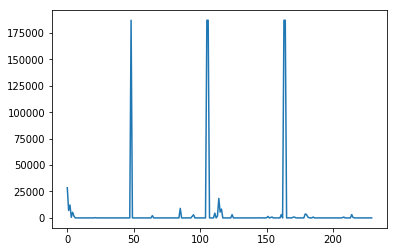

In [199]:
plt.plot(range(len(y.columns)-1), list(y.iloc[0,1:]))

In [212]:
eventQ.to_csv('q_de')

,event,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,q_9,...,q_297,q_298,q_300,q_302,q_304,q_311,q_314,q_319,q_320,event_num
0,1,28503.0,7070.0,12238.0,557.0,5356.0,1737.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,187005.0
1,2,279.0,30.0,36.0,36.0,47.0,0.0,833.0,30.0,0.0,...,11.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,833.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6984.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9792.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24192.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3482.0
6,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7164.0
7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5773.0
8,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2063.0
9,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,478.0
